# Тестовое задание для `REALWEB Analytics camp`

## Обзор данных

In [169]:
# импорт библиотек
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from scipy import stats as st
from sklearn.linear_model import LinearRegression

In [33]:
# загрузка файла
df = pd.read_csv('summer_camp_data.csv')

In [11]:
# функция с обзором данных
def first_view(df):
    raw_shape_df = df.shape
    display(df.head(3))
    display(df.info())
    print(f'Размер датасета: {raw_shape_df}')
    print(f'Всего дубликатов: {df.duplicated().sum()}')
    
    cols = []
    nans = []
    pnans = []
    
    if df.isna().sum().sum() == 0:
        print('Пропущенных значений не обнаружено')
    else:
        for i in df.columns:
            if df[i].isna().sum() != 0:
                cols.append(i)
                nans.append(df[i].isna().sum())
                pnans.append(df[i].isna().sum() / df.shape[0] * 100)
                
    if len(cols) != 0:
        print('\n')
        print('Пропущенные значения по столбцам:')
        display(
            pd.DataFrame(
                {
                    'column_name': cols, 
                    'number_of_na': nans, 
                    'percent_of_na': pnans
                }
            ).style.format({'percent_of_na': '{:.2f}%'}).background_gradient()
        )
    return raw_shape_df

In [81]:
# обзор данных и создание переменной с изначальным размером датасета
raw_shape_df = first_view(df)

,date,source,medium,delivery_available,device_type,promo_activated,filter_used,pageviews,visits,productClick,addToCart,checkout,transactions,revenue,avg_transaction_cost
0,2020-05-11,google,organic,Не определено,Десктоп,no,no,3120,1233,5240,1048,525,90,86649.0,962.766667
1,2020-05-11,yandex,cpc,Не определено,Мобайл,yes,no,3302,544,9930,1984,1416,217,244478.0,1126.626728
2,2020-05-11,google,cpc,Не определено,Мобайл,no,no,2970,1450,5460,1090,599,100,105150.0,1051.500000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52721 entries, 0 to 52720
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   date                  52721 non-null  object 
 1   source                52721 non-null  object 
 2   medium                52721 non-null  object 
 3   delivery_available    52721 non-null  object 
 4   device_type           52721 non-null  object 
 5   promo_activated       52721 non-null  object 
 6   filter_used           52721 non-null  object 
 7   pageviews             52721 non-null  int64  
 8   visits                52721 non-null  int64  
 9   productClick          52721 non-null  int64  
 10  addToCart             52721 non-null  int64  
 11  checkout              52721 non-null  int64  
 12  transactions          52721 non-null  int64  
 13  revenue               52721 non-null  float64
 14  avg_transaction_cost  38450 non-null  float64
dtypes: float64(2), int6

None

Размер датасета: (52721, 15)
Всего дубликатов: 0


Пропущенные значения по столбцам:


,column_name,number_of_na,percent_of_na
0,avg_transaction_cost,14271,27.07%


In [82]:
# переведем в формат даты столбец date
df.date = pd.to_datetime(df.date)

display(df.date.min())
df.date.max()

Timestamp('2020-01-01 00:00:00')

Timestamp('2020-09-30 00:00:00')

Данные за период с 1 января 2020 г. по 30 сентября 2020 г. Пропущенных значений и дубликатов нет.

## Суммарный доход по рекламным каналам

In [60]:
# считаем доход по каналам (для каждого канала суммируется доход)
revenue_by_source = (
    df
    .pivot_table(index='source', values='revenue', aggfunc='sum')
    .reset_index()
    .sort_values('revenue', ascending=False)
)

# считаем процент от общего дохода
revenue_by_source['percent_of_total'] = (
    revenue_by_source.revenue / revenue_by_source.revenue.sum() * 100
)

# вывод
(
    revenue_by_source
    .style
    .format({'percent_of_total': '{:.1f}%', ь'revenue': '{:.0f}'})
    .background_gradient()
)

,source,revenue,percent_of_total
21,yandex,467299311,36.6%
12,google,456344188,35.8%
0,(direct),238355148,18.7%
3,admitad,65738858,5.2%
9,eLama,16432390,1.3%
7,cityads,14290767,1.1%
18,promo,5363685,0.4%
8,co-promo,3347826,0.3%
15,newsletter,2225289,0.2%
17,other,1839654,0.1%


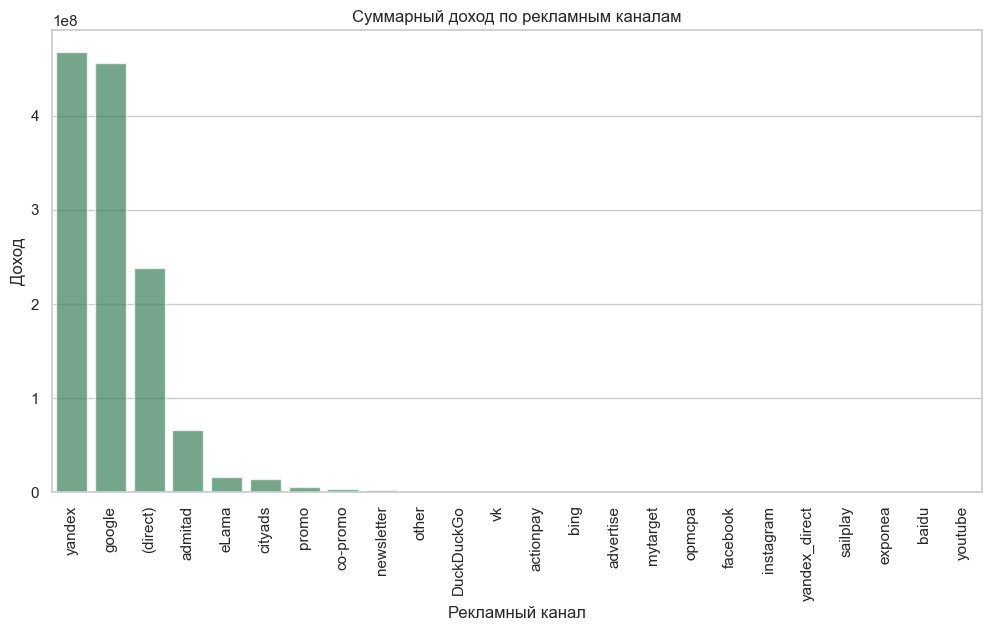

In [42]:
sns.set_theme(rc={'figure.figsize': (12, 6)}, style='whitegrid')

ax = sns.barplot(
    data=revenue_by_source, 
    x='source', 
    y='revenue', 
    color='seagreen', 
    alpha=0.7)

plt.title('Суммарный доход по рекламным каналам')
plt.xlabel('Рекламный канал')
plt.ylabel('Доход')
plt.xticks(rotation=90)
#ax.bar_label(ax.containers[0])
plt.show()

Наибольший доход приносят `yandex` и `google` - `36.6%` и `35.8%` от суммарного дохода соответственно.

## Средний чек транзакции

In [64]:
# считаем средний чек транзакции
df['avg_transaction_cost'] = df.revenue / df.transactions

In [75]:
df.avg_transaction_cost.describe()

count     38450.000000
mean       1219.605578
std        1030.907320
min           0.000000
25%         975.136288
50%        1138.000000
75%        1329.653893
max      157370.375000
Name: avg_transaction_cost, dtype: float64

In [83]:
# создадим столбец месяца
df['month'] = df.date.dt.month

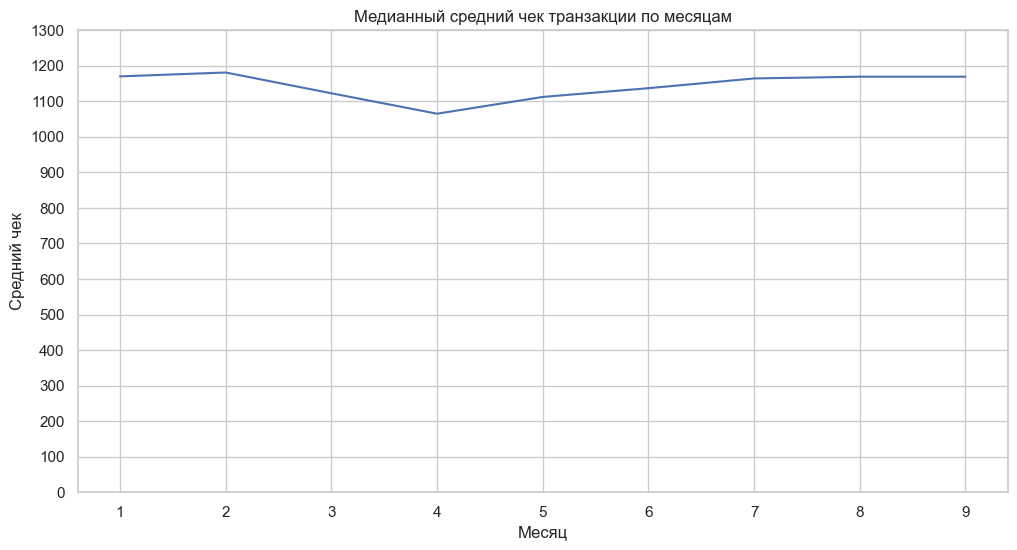

In [93]:
median_avg_cost = (
    df
    .pivot_table(index='month', values='avg_transaction_cost', aggfunc='median')
)
sns.lineplot(data=median_avg_cost, x='month', y='avg_transaction_cost')
plt.yticks(range(0, 1400, 100))
plt.title('Медианный средний чек транзакции по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Средний чек')
plt.show()

После февраля наблюдается падение среднего чека транзакции. В период с марта по июль средний чек ниже чем в остальные месяцы.

In [101]:
median_avg_cost_promo = (
    df
    .pivot_table(
        index=['month', 'promo_activated'], 
        values='avg_transaction_cost', 
        aggfunc='median')
)

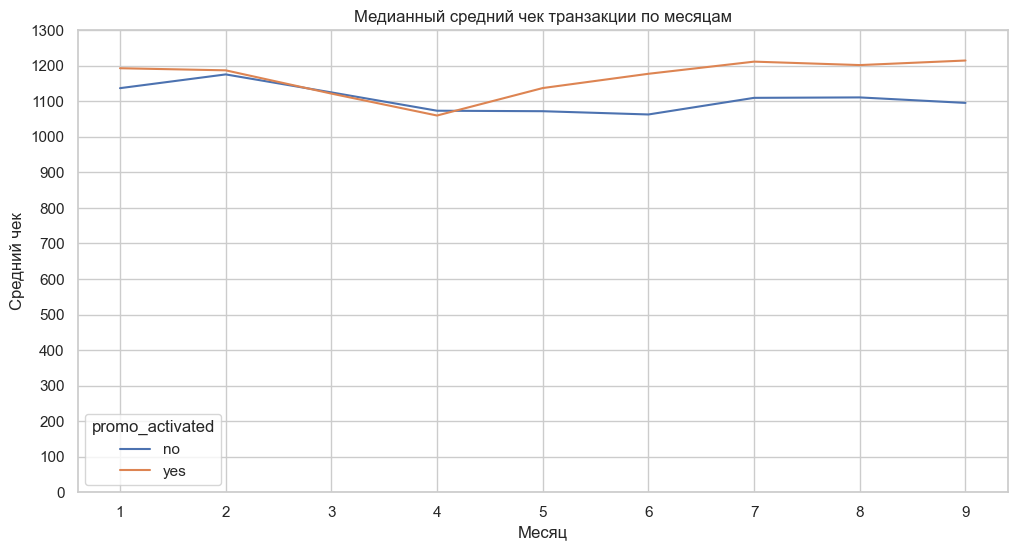

In [102]:
sns.lineplot(
    data=median_avg_cost_promo, 
    x='month', 
    y='avg_transaction_cost', 
    hue='promo_activated')
plt.yticks(range(0, 1400, 100))
plt.title('Медианный средний чек транзакции по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Средний чек')
plt.show()

Средний чек снижался схожим образом для пользователей с промокодом и без до апреля, начиная с мая средний чек с промокодом выше, чем без. Короновирусные ограничения вводились в марте и апреле - средний чек снижался, в мае пользователи стали больше покупать с использованием промокодов.


## Конверсия в транзакцию в выходные и будние дни

In [124]:
# день недели 
df['weekday'] = df.date.dt.weekday 
# выходные дни
df.loc[(df.weekday == 5) | (df.weekday == 6), 'is_weekend'] = True 
df.is_weekend = df.is_weekend.fillna(False)
# конверсия в транзакцию из посещений
df['cr'] = df.transactions / df.visits * 100

# две выборки - конверсия в выходные дни и конверсия в будни
sample_1 = df[df.is_weekend == True].cr
sample_2 = df[df.is_weekend == False].cr

Создали две выборки из данных - конверсия из посещений в транзакцию в выходные дни и конверсия в будни. Проведем *t*-тест для проверки гипотезы о равенстве средних. Параметру `equal_var` зададим значение `False`, т.к. не можем говорить о равенстве дисперсий и размеры выборок неравны.

**Нулевая гипотеза**: коэффициент конверсии в транзакцию в выходные и будние дни одинаковый.

**Альтернативная гипотеза**: коэффициент конверсии в транзакцию в выходные и будние дни различается.

In [143]:
alpha = 0.05

results = st.ttest_ind(sample_1, sample_2, equal_var=False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 7.476651926325496e-11
Отвергаем нулевую гипотезу


Т.к. значение `p < 0.05`, отвергаем нулевую гипотезу, принимаем альтернативную. Конверсия в выходные и будние дни достоверно различается. Это справедливо и для значения `p = 0.01`, т.е. с уверенностью в 99% конверсия в выходные и будние дни различается.

## Объем дохода, полученного с пользователей, приведенных на сайт контекстной рекламой

Посчитаем доход, полученный с пользователей, приведенных на сайт контекстной рекламой по дням. Далее посчитаем куммулятивный доход.

In [299]:
df_cpc = (
    df[df.medium == 'cpc'][['date', 'revenue']]
    .pivot_table(index='date', values='revenue', aggfunc='sum')
    .reset_index()
)
df_cpc.head()

,date,revenue
0,2020-01-01,1278862.0
1,2020-01-02,1774136.0
2,2020-01-03,1889112.0
3,2020-01-04,2072428.0
4,2020-01-05,2061834.0


In [300]:
cummulative_revenue = df_cpc.apply(
    lambda x: df_cpc[df_cpc['date'] <= x['date']].agg(
        {'date': 'max', 'revenue': 'sum'}
    ),
    axis=1
).rename(columns={'revenue': 'revenue_cummulative'})

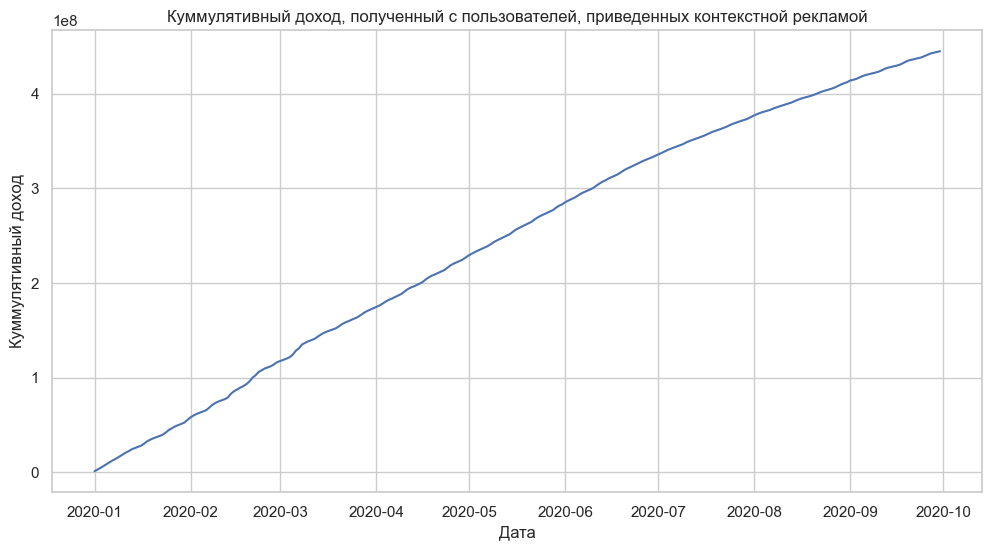

In [301]:
sns.lineplot(data=cummulative_revenue, x='date', y='revenue_cummulative')
plt.title(
    'Куммулятивный доход, полученный с пользователей, приведенных контекстной рекламой'
)
plt.xlabel('Дата')
plt.ylabel('Куммулятивный доход')
plt.show()

График куммулятивного дохода похож на линейный и т.к. у нас нет других данных, влияющих на данный показатель, то можно построить модель линейной регрессии для предсказания дохода на пол года вперед.

In [305]:
cummulative_revenue.index.max()

273

Т.к. у нас есть данные за каждый день, то за `X` возьмем значения индекса (для обучения модели - 0-273). Предсказывать будем на следующие полгода - 180 дней (индексы 274-454).

In [306]:
# набор данных для обучения модели
X_train = np.array([cummulative_revenue.index]).reshape((-1, 1))
y_train = np.array(cummulative_revenue.revenue_cummulative)

# модель линейной регрессии
regressor = LinearRegression()

# обучение модели
regressor.fit(X_train, y_train)

# коэффициенты регрессии
print('Intercept:', regressor.intercept_)
print('Coefficients:', regressor.coef_)

# предсказываем значения для новых данных
X_new = np.arange(274, 454).reshape((-1, 1))
y_pred = regressor.predict(X_new)

Intercept: 17845872.01313868
Coefficients: [1670866.89033448]


In [310]:
# столбец со значением предсказанное ли значение
cummulative_revenue['is_predict'] = False

# создадим датафрейм с предсказанными значениями
prediction = pd.DataFrame(y_pred).rename(columns={0: 'revenue_cummulative'})
# столбец со значением предсказанное ли значение
prediction['is_predict'] = True
# столбец с датами
prediction['date'] = pd.date_range('2020-10-01', '2021-03-29')

In [311]:
# объединяем датафреймы с предсказанными значениями и реальными
real_and_pred_revenue = pd.concat(
    [cummulative_revenue, prediction], 
    ignore_index=True
)

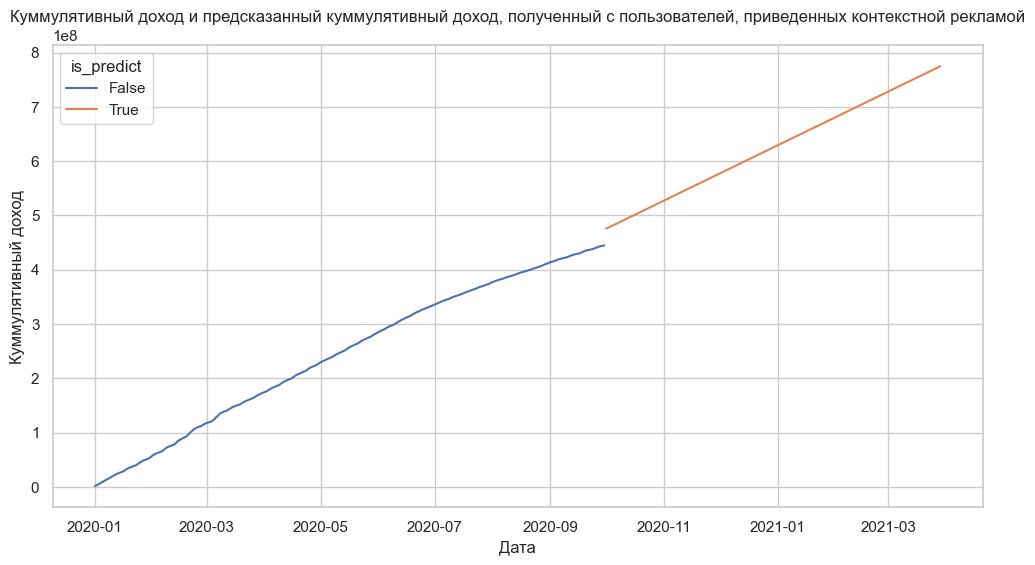

In [313]:
sns.lineplot(
    data=real_and_pred_revenue, 
    x='date', 
    y='revenue_cummulative', 
    hue='is_predict')
plt.title(
    'Куммулятивный доход и предсказанный куммулятивный доход, полученный с пользователей, приведенных контекстной рекламой'
)
plt.xlabel('Дата')
plt.ylabel('Куммулятивный доход')
plt.show()

In [333]:
round(
    prediction.revenue_cummulative.max() - 
    prediction.revenue_cummulative.min()
)

299085173

К концу сентября доход стал несколько уменьшаться, поэтому видим небольшой разрыв между предсказанными значениями и реальными, вероятно, есть еще какие-то неучтенные факторы, влияющие на доход. При такой грубой оценке, можно сказать, что в следующие полгода доход будет около 299 млн. у.е.